In [50]:
import warnings
warnings.filterwarnings("ignore")

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [52]:
# dropping the location column in the dataframes
def drop_location(dataframe):
    return dataframe.drop(columns=['Location'], inplace=True)

In [53]:
def convert_to_datetime(df):
    df['Current_Date'] = pd.to_datetime(df['Current_Date'])
    return df

In [54]:
colombo_df = pd.read_csv('Cleaned Data/colombo_df.csv')
colombo_df

,HCHO_Reading,Location,Current_Date
0,0.000197,Colombo,2019-01-01
1,0.000263,Colombo,2019-01-02
2,0.000099,Colombo,2019-01-03
3,0.000210,Colombo,2019-01-04
4,0.000179,Colombo,2019-01-05
...,...,...,...
1275,0.000182,Colombo,2023-12-24
1276,0.000343,Colombo,2023-12-25
1277,0.000118,Colombo,2023-12-27
1278,0.000140,Colombo,2023-12-30


In [55]:
drop_location(colombo_df)
convert_to_datetime(colombo_df)
colombo_df

,HCHO_Reading,Current_Date
0,0.000197,2019-01-01
1,0.000263,2019-01-02
2,0.000099,2019-01-03
3,0.000210,2019-01-04
4,0.000179,2019-01-05
...,...,...
1275,0.000182,2023-12-24
1276,0.000343,2023-12-25
1277,0.000118,2023-12-27
1278,0.000140,2023-12-30


In [56]:
scaler = MinMaxScaler(feature_range=(0, 1))
colombo_df['HCHO_reading_normalized'] = scaler.fit_transform(colombo_df['HCHO_Reading'].values.reshape(-1, 1))

In [57]:
# splitting into training and testing split
train_size = int(len(colombo_df) * 0.8)
test_size = len(colombo_df) - train_size
train, test = colombo_df.iloc[0:train_size], colombo_df.iloc[train_size:len(colombo_df)]

In [58]:
# Function to create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

In [59]:
sequence_length = 10
x_train = create_sequences(train['HCHO_reading_normalized'], sequence_length)
x_test = create_sequences(test['HCHO_reading_normalized'], sequence_length)

# reshapinig the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [60]:
# creating the model
colombo_model = Sequential()
colombo_model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
colombo_model.add(Dropout(0.2))
colombo_model.add(LSTM(units=50))
colombo_model.add(Dropout(0.2))
colombo_model.add(Dense(units=1))

print(colombo_model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

None


In [61]:
colombo_model.compile(optimizer='adam', loss='mean_squared_error')

# training the model
colombo_model.fit(x_train, train['HCHO_reading_normalized'][sequence_length:], epochs=100, batch_size=32)

# evaluating the model
loss = colombo_model.evaluate(x_test, test['HCHO_reading_normalized'][sequence_length:])

# predicting the values
colombo_predictions = colombo_model.predict(x_test)

# getting the actual values using inverse transformation
colombo_predictions_actual = scaler.inverse_transform(colombo_predictions)

Epoch 1/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0787
Epoch 2/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0301
Epoch 3/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0347
Epoch 4/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0298
Epoch 5/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0304
Epoch 6/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0349
Epoch 7/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0347
Epoch 8/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0366
Epoch 9/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0312
Epoch 10/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0335
Epoch 11/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0333
Epoch 12/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0320
Epoch 13/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0322
Epoch 14/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0309
Epoch 15/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0335
Epoc

In [62]:
colombo_actual_vals = scaler.inverse_transform(test["HCHO_reading_normalized"][sequence_length:].values.reshape(-1, 1))

In [63]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(colombo_actual_vals, colombo_predictions_actual)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(colombo_actual_vals, colombo_predictions_actual)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f"Colombo MAE is {mae}")
print(f"Colombo MSE is {mse}")
print(f"Colombo RMSE is {rmse}")

Colombo MAE is 6.261697956832717e-05
Colombo MSE is 6.228010576622952e-09
Colombo RMSE is 7.891774563824635e-05


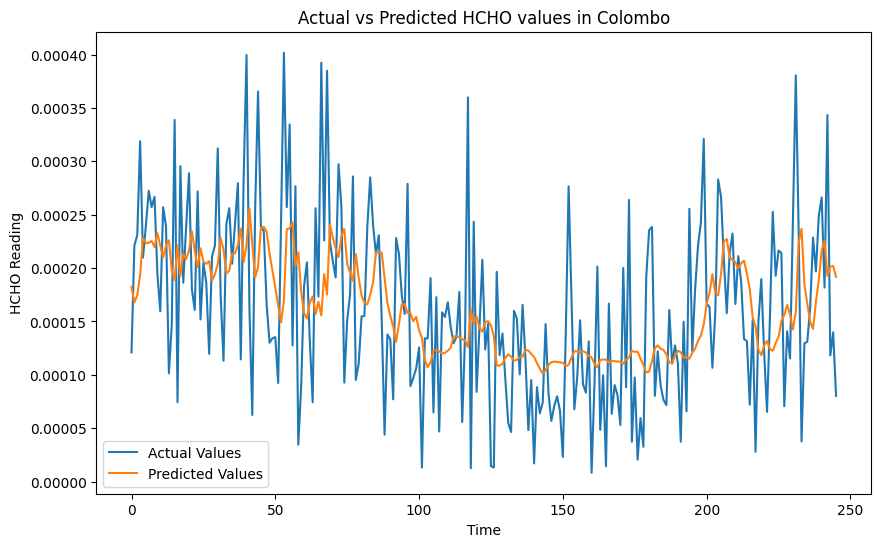

In [64]:
# plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(colombo_actual_vals, label='Actual Values')
plt.plot(colombo_predictions_actual, label='Predicted Values')
plt.title('Actual vs Predicted HCHO values in Colombo')
plt.xlabel("Time")
plt.ylabel("HCHO Reading")
plt.legend()
plt.show()
